In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try: # Currently, memory growth needs to be the same across GPUs 
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e: # Memory growth must be set before GPUs have been initialized print(e)
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt

In [3]:
#학습 데이터와 테스트 데이터 분리
(x_train,y_train),(x_test,y_test)=keras.datasets.mnist.load_data()

# 이미지를 [0,1] 범위로 스케일링
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
BATCH_SIZE=128
EPOCHS=2000
Z_DIMENSIONS=32
data=np.reshape(x_train, (x_train.shape[0], 28,28,1)) # 컨볼루션의 입력: (배치 크기x이미지 높이x이미지 너비x채널수) // 흑백이므로 채널은 1 

In [119]:
# 판별자 신경망 구축하기 
def make_discriminator():
    model=keras.Sequential()
    model.add(keras.layers.Conv2D(64,(5,5),strides=(2,2),padding='same',activation='relu',input_shape=(28,28,1)))
    model.add(keras.layers.Dropout(0.4))
    
    model.add(keras.layers.Conv2D(128,(5,5),strides=(2,2),padding='same',activation='relu'))
    model.add(keras.layers.Dropout(0.4))
    
    model.add(keras.layers.Conv2D(256,(5,5),strides=(2,2),padding='same',activation='relu'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1,activation='sigmoid'))
    
    return model

In [121]:
# 판별자 생성
discriminator = make_discriminator()
discriminator.summary()
# 판별자 컴파일 (결과에서 역전파된 손실값을 이용해서 진짜 이미지와 가짜 이미지를 더 잘 구별하도록 매개변수를 조정하면 됨)
discriminator.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adam(lr=0.0004),metrics=['accuracy'])

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_84 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_82 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_83 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_84 (Dropout)         (None, 4, 4, 256)         0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 4096)            

In [122]:
# 생성자 신경망 구축하기
def make_generator():
    model=keras.Sequential()
    # 완전 연결 레이어 
    model.add(keras.layers.Dense(7*7*64, input_shape=(Z_DIMENSIONS,)))
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Reshape((7,7,64)))
    model.add(keras.layers.Dropout(0.4)) #학습을 유지할 뉴런의 비율
    
    # 두 개의 디컨볼루션 레이어 (컨볼루션 레이어의 반대 기능 수행, 활성화 맵을 가져와서 이미지 구성) 
    model.add(keras.layers.UpSampling2D())
    model.add(keras.layers.Conv2DTranspose(32,kernel_size=5,padding='same',activation=None,))
    model.add(keras.layers.BatchNormalization(momentum=0.9))
    model.add(keras.layers.LeakyReLU())
    
    model.add(keras.layers.UpSampling2D())
    model.add(keras.layers.Conv2DTranspose(16,kernel_size=5,padding='same',activation=None,))
    model.add(keras.layers.BatchNormalization(momentum=0.9))
    model.add(keras.layers.LeakyReLU())
    
    # 28x28x16 활성화 맵을 28x28x1 이미지로 축소하는 컨볼루션 레이어 
    model.add(keras.layers.Conv2D(1,kernel_size=5, padding='same', activation='sigmoid'))
    
    return model

In [123]:
# 생성자 생성
# 컴파일 x (손실값 계산 후 역전파해주는 것은 판별자가 담당함, 생성자에서는 손실값을 이용해서 가짜 이미지를 더 잘 생성하도록 매개변수를 조정하면 됨)
generator = make_generator()

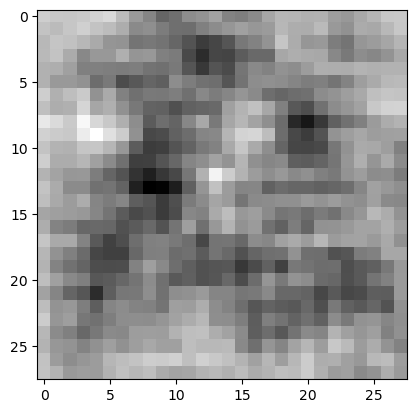

In [124]:
noise=tf.random.normal([1,Z_DIMENSIONS])
generated_image=generator(noise,training=False)

plt.imshow(generated_image[0,:,:,0],cmap='gray')
plt.show()

In [125]:
# GAN 구축 (함수 API 방식)
z=keras.layers.Input(shape=(Z_DIMENSIONS,)) # 입력 레이어는 Z_DIMENSIONS=32 크기의 랜덤 노이즈 배열을 받는다. 
fake_image=generator(z) # 입력 레이어는 생성와 연결되고 생성자의 출력으로 28x28 이미지를 얻는다. 
discriminator.trainable=False # 생성자 훈련을 위해 판별자 신경망의 매개변수 trainable를 False로 고정한다. 
prediction=discriminator(fake_image) # 가짜 이미지를 판별자 신경망에 전달하면 이미지가 가짜인지 진짜인지에 대한 예측값이 출력된다.
gan_model=keras.models.Model(z,prediction) # 입력이 z이고 출력이 prediction인 GAN 모델을 구축한다.

In [126]:
# GAN 모델 컴파일
gan_model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0004),metrics=['accuracy'])

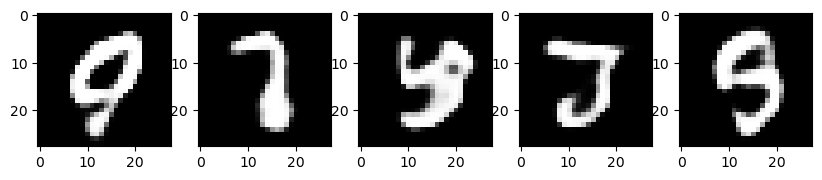

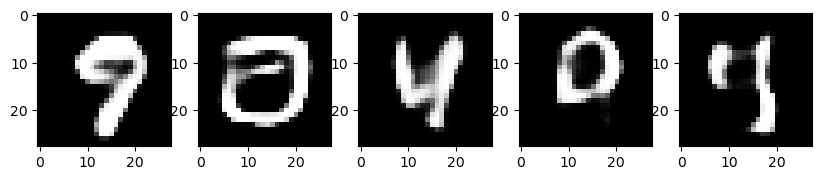

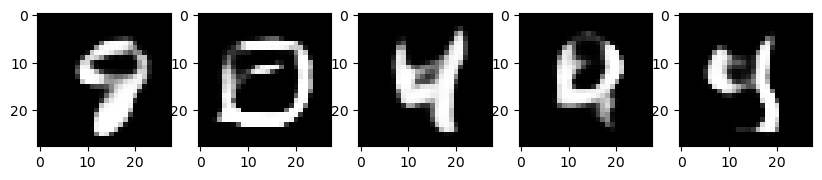

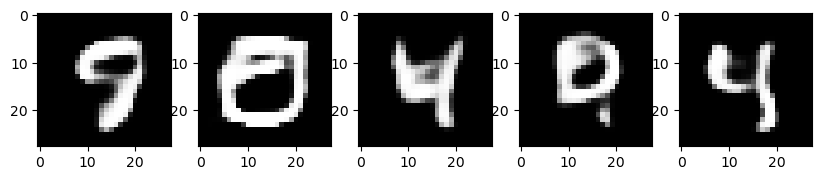

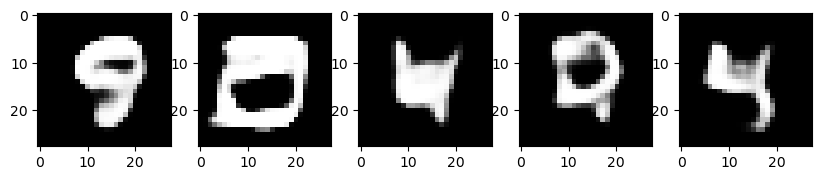

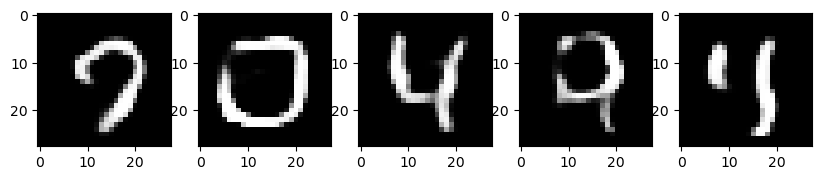

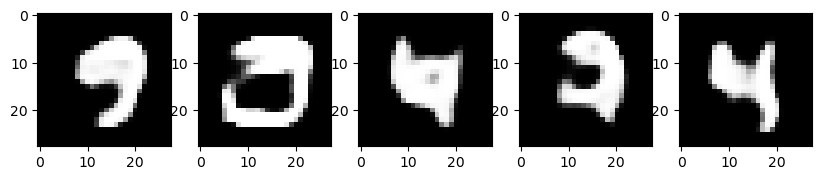

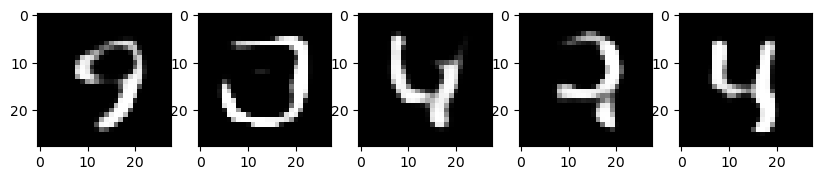

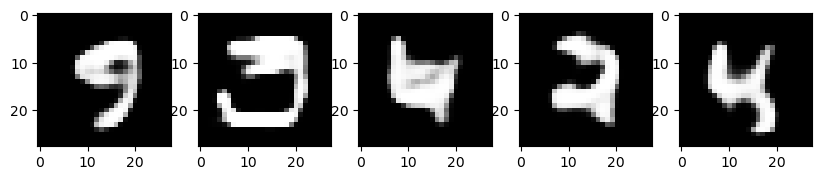

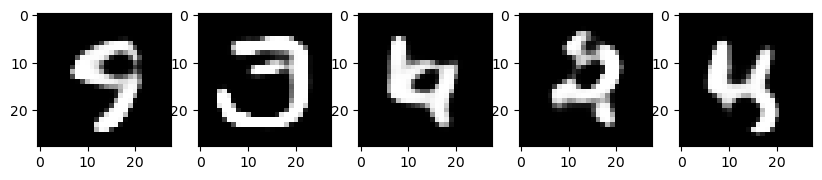

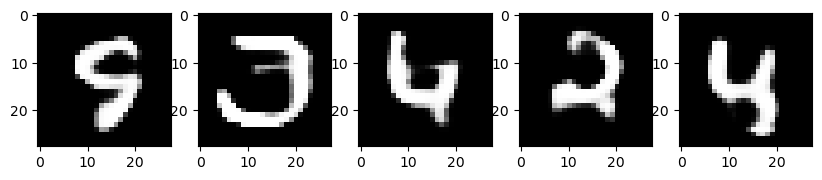

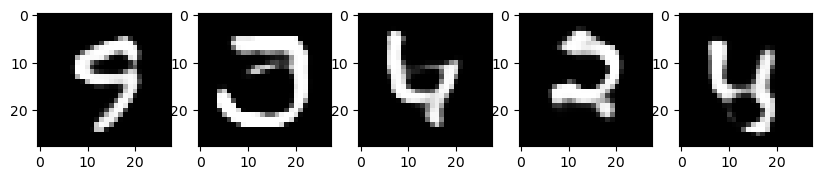

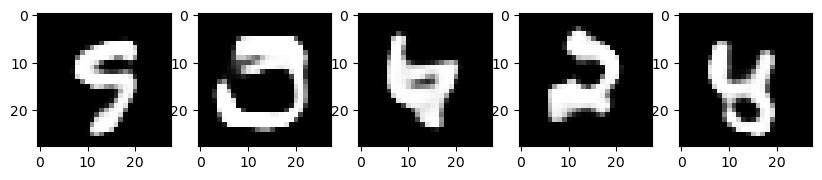

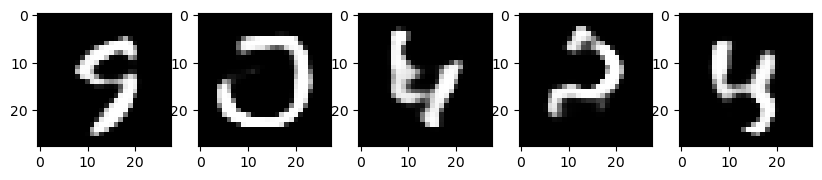

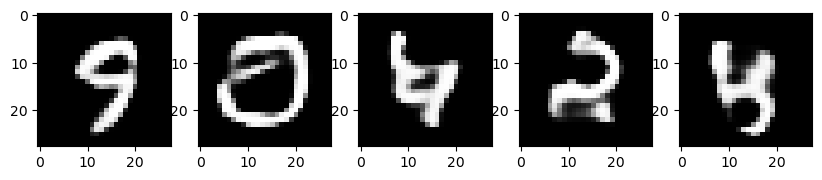

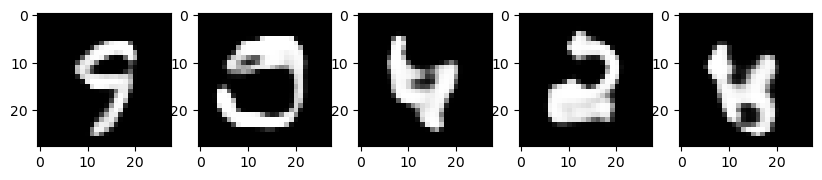

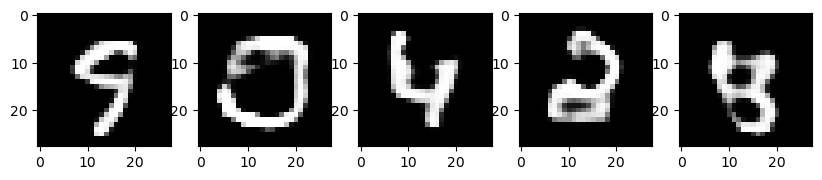

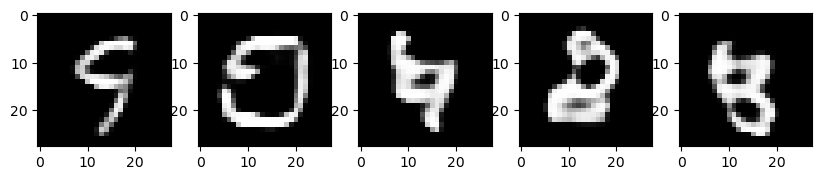

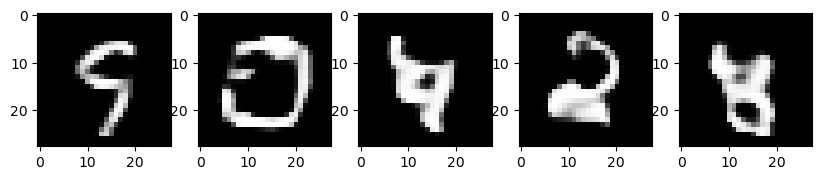

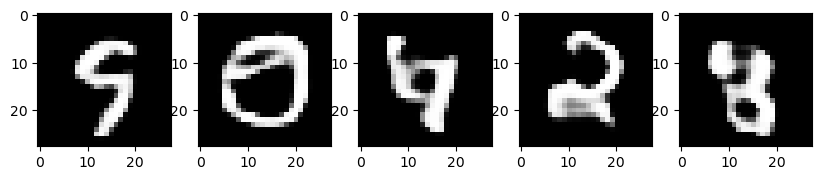

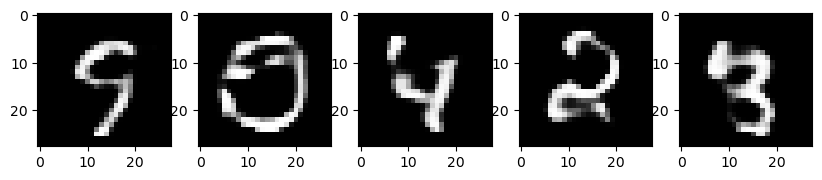

In [129]:
# 테스트용 노이즈
test_noise = np.random.uniform(-1.0,1.0,size=[5,Z_DIMENSIONS])

# GAN의 학습
def train_gan():
    for i in range(EPOCHS):
        real_images=np.reshape(
            data[np.random.choice(data.shape[0],
                                  BATCH_SIZE,
                                  replace=False)], (BATCH_SIZE,28,28,1))
        fake_images = generator.predict(
            np.random.uniform(-1.0,1.0,
                              size=[BATCH_SIZE,Z_DIMENSIONS]))
        # 진짜 이미지와 가짜 이미지를 붙인다. 
        x=np.concatenate((real_images,fake_images))
        # 정답 레이블을 생성한다.
        y=np.ones([2*BATCH_SIZE,1])
        y[BATCH_SIZE:,:]=0
        # 판별자를 훈련한다.
        discriminator.train_on_batch(x,y)
        noise=np.random.uniform(-1.0,1.0,size=[BATCH_SIZE, Z_DIMENSIONS])
        y=np.ones([BATCH_SIZE,1])
        # 잡음을 입력해서 생성자를 훈련한다. 
        gan_model.train_on_batch(noise,y)
        
        # 훈련 중 모델 테스트 
        if i%100 == 0:
            generated_image=generator.predict(test_noise)
            plt.figure(figsize=(10,10))
            for i in range(generated_image.shape[0]):
                plt.subplot(1,5,i+1)
                plt.imshow(generated_image[i, :, :, 0],cmap='gray')
            plt.show()
train_gan()
print()